In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 

In [3]:
########################   读取数据  #########################################
sheet = pd.read_excel('data_input/中国10债Non-Trend.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet.set_index('Date', inplace=True) 
full_date_range = pd.date_range(start=sheet.index.min(), end=sheet.index.max()+pd.Timedelta(days=60), freq='D') 
sheet = sheet.reindex(full_date_range)
# 有月度数据 所以 数据 处理逻辑 就是 全部填充 然后再变成 工作日数据
#############  处理缺失值 ##############
fill_methods = {
    '10年期美国国债收益率80日环差': 'interpolate',
    '南华工业品指数80日环比':'interpolate',
    '新增人民币贷款/中长期同差':'interpolate',  # 月度数据
    'M2同比': 'interpolate', # 月度数据
    'M1同比': 'interpolate' # 月度数据
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
last_day = sheet['中国10年期国债收益率Non-Trend/F0.2'].last_valid_index()
sheet = sheet.reset_index().rename(columns={'index': 'Date'})
########## 只保留工作日数据(周一到周五) ##########
sheet = sheet[sheet['Date'].dt.dayofweek < 5]
sheet_daily = sheet.copy()
########################   因子处理  #########################################
sheet_daily['10年期美国国债收益率80日环差_提前80天'] = sheet_daily['10年期美国国债收益率80日环差'].shift(80)
sheet_daily['南华工业品指数80日环比_提前55天'] = sheet_daily['南华工业品指数80日环比'].shift(55)
sheet_daily['新增人民币贷款/中长期同差_提前160天'] = sheet_daily['新增人民币贷款/中长期同差'].shift(160)
sheet_daily['M2同比_提前140天'] = sheet_daily['M2同比'].shift(140)
sheet_daily['M1同比_提前60天'] = sheet_daily['M1同比'].shift(60)

sheet_daily = sheet_daily[sheet_daily['Date'] >= '2020-08-01']  
############ 不同因子有效期不同  ##########
sheet_daily['10年期美国国债收益率80日环差_提前80天_2023-01-01之后'] = sheet_daily['10年期美国国债收益率80日环差_提前80天'].loc[sheet_daily['Date'] >= '2023-01-01']
sheet_daily['南华工业品指数80日环比_提前55天_2022-11-01之后'] = sheet_daily['南华工业品指数80日环比_提前55天'].loc[sheet_daily['Date'] >= '2022-11-01']
#############  删除预测指标最后一天之前 为空值的一整行  ##############
sheet_daily = sheet_daily[(sheet_daily['Date'] > last_day) | sheet_daily['中国10年期国债收益率Non-Trend/F0.2'].notna()]

In [4]:
sheet_daily.head()

,Date,中国10年期国债收益率Non-Trend/F0.2,10年期美国国债收益率80日环差,南华工业品指数80日环比,新增人民币贷款/中长期同差,M2同比,M1同比,10年期美国国债收益率80日环差_提前80天,南华工业品指数80日环比_提前55天,新增人民币贷款/中长期同差_提前160天,M2同比_提前140天,M1同比_提前60天,10年期美国国债收益率80日环差_提前80天_2023-01-01之后,南华工业品指数80日环比_提前55天_2022-11-01之后
10443,2020-08-03,-0.1132,-0.21,0.1641,3945.612903,10.670968,7.006452,-1.13,-0.1237,3092.032258,8.506452,5.961290,NaN,NaN
10444,2020-08-04,-0.1148,-0.21,0.1521,3947.483871,10.661290,7.041935,-1.13,-0.1134,3173.903226,8.496774,6.003226,NaN,NaN
10445,2020-08-05,-0.0834,-0.21,0.1468,3949.354839,10.651613,7.077419,-1.29,-0.1074,3255.774194,8.487097,6.045161,NaN,NaN
10446,2020-08-06,-0.0760,-0.21,0.1406,3951.225806,10.641935,7.112903,-1.31,-0.0989,3337.645161,8.477419,6.087097,NaN,NaN
10447,2020-08-07,-0.0736,-0.06,0.1284,3953.096774,10.632258,7.148387,-1.27,-0.1209,3419.516129,8.467742,6.129032,NaN,NaN


In [5]:
sheet_daily_1 = sheet_daily[['Date','10年期美国国债收益率80日环差_提前80天_2023-01-01之后','南华工业品指数80日环比_提前55天_2022-11-01之后', 
                  '新增人民币贷款/中长期同差_提前160天','M2同比_提前140天','M1同比_提前60天']].copy()
sheet_daily_1


,Date,10年期美国国债收益率80日环差_提前80天_2023-01-01之后,南华工业品指数80日环比_提前55天_2022-11-01之后,新增人民币贷款/中长期同差_提前160天,M2同比_提前140天,M1同比_提前60天
10443,2020-08-03,NaN,NaN,3092.032258,8.506452,5.961290
10444,2020-08-04,NaN,NaN,3173.903226,8.496774,6.003226
10445,2020-08-05,NaN,NaN,3255.774194,8.487097,6.045161
10446,2020-08-06,NaN,NaN,3337.645161,8.477419,6.087097
10447,2020-08-07,NaN,NaN,3419.516129,8.467742,6.129032
...,...,...,...,...,...,...
12117,2025-03-04,0.23,0.0173,-2451.870968,6.300000,-3.700000
12118,2025-03-05,0.19,0.0038,-2225.387097,6.300000,-3.700000
12119,2025-03-06,0.17,0.0051,-1998.903226,6.300000,-3.700000
12120,2025-03-07,0.18,-0.0125,-1772.419355,6.300000,-3.700000


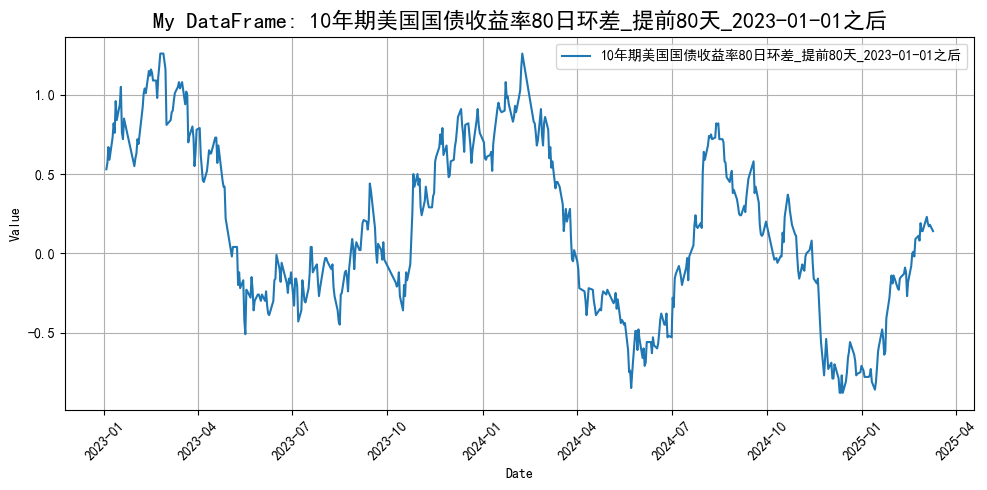

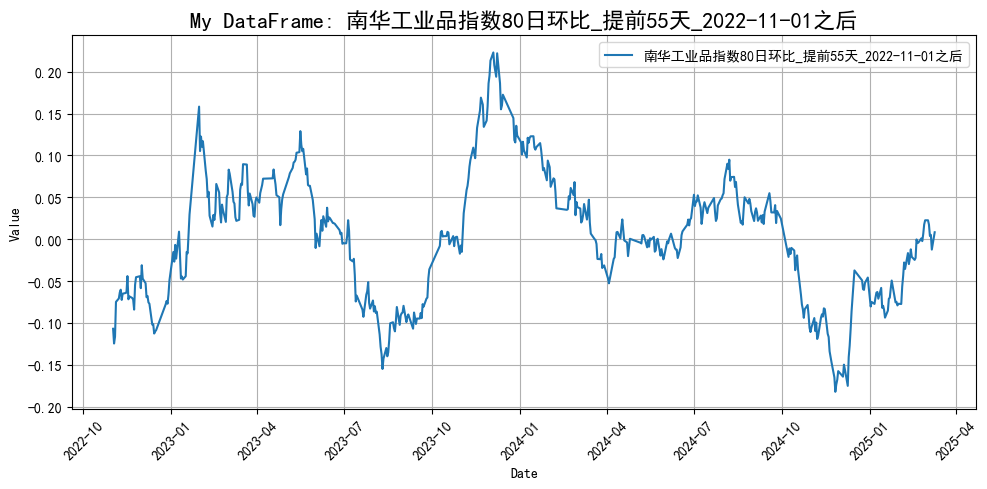

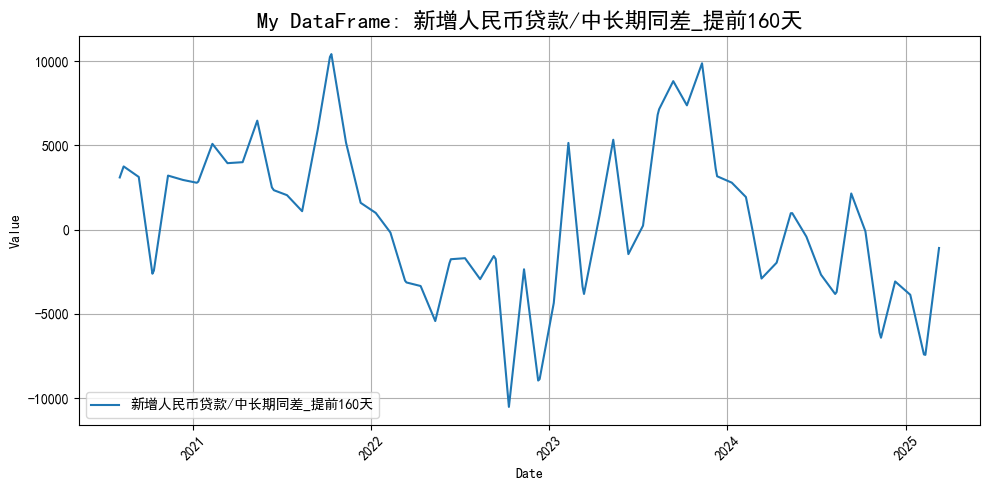

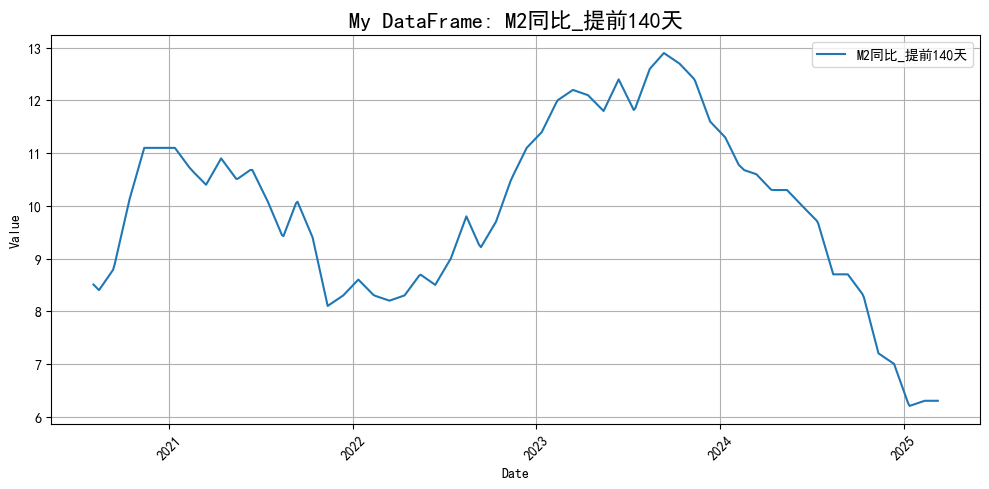

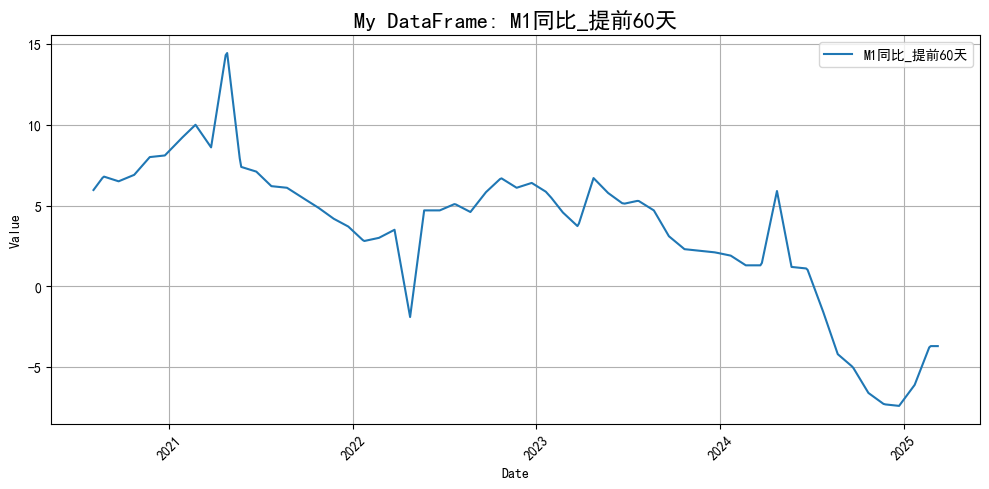

In [6]:
sheet_daily_1_plot = sheet_daily_1.set_index('Date')
plot_factors_by_pattern(sheet_daily_1_plot, 'My DataFrame')

In [7]:
sheet_daily.columns

Index(['Date', '中国10年期国债收益率Non-Trend/F0.2', '10年期美国国债收益率80日环差', '南华工业品指数80日环比',
       '新增人民币贷款/中长期同差', 'M2同比', 'M1同比', '10年期美国国债收益率80日环差_提前80天',
       '南华工业品指数80日环比_提前55天', '新增人民币贷款/中长期同差_提前160天', 'M2同比_提前140天',
       'M1同比_提前60天', '10年期美国国债收益率80日环差_提前80天_2023-01-01之后',
       '南华工业品指数80日环比_提前55天_2022-11-01之后'],
      dtype='object')

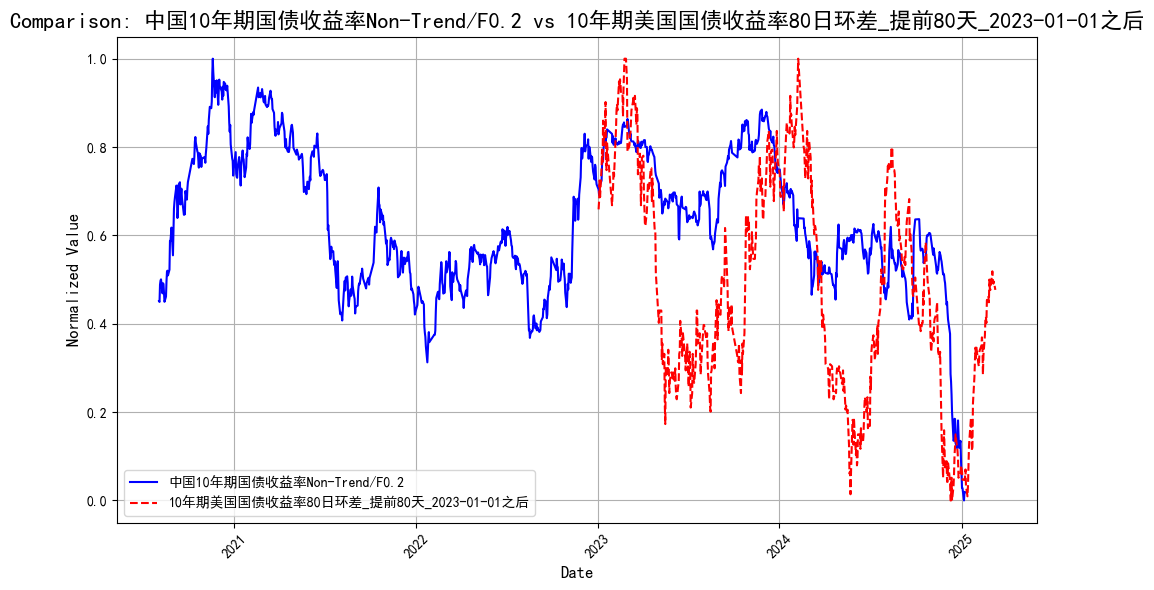

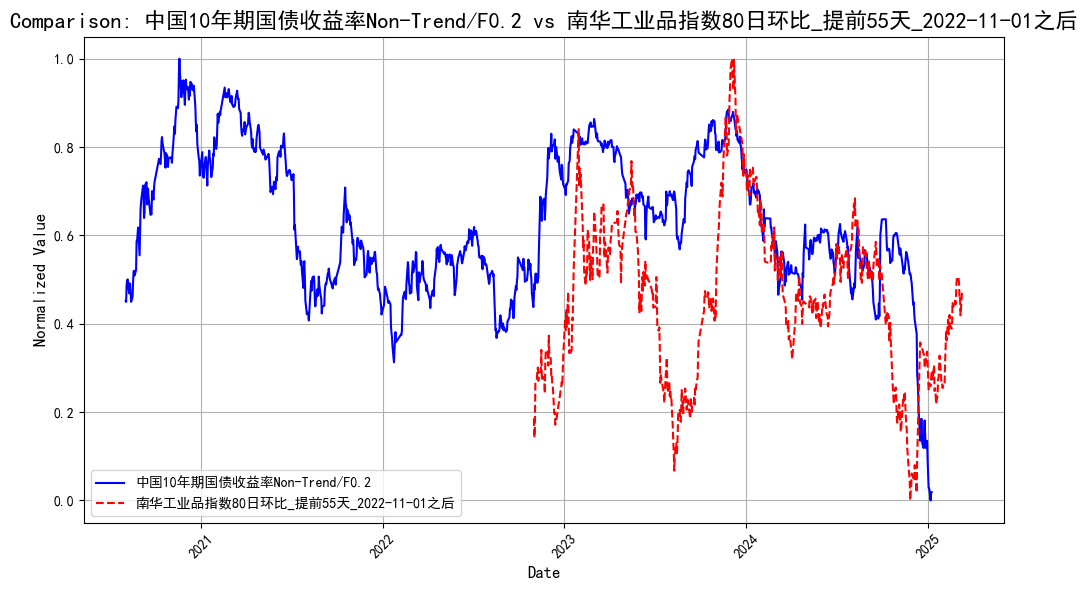

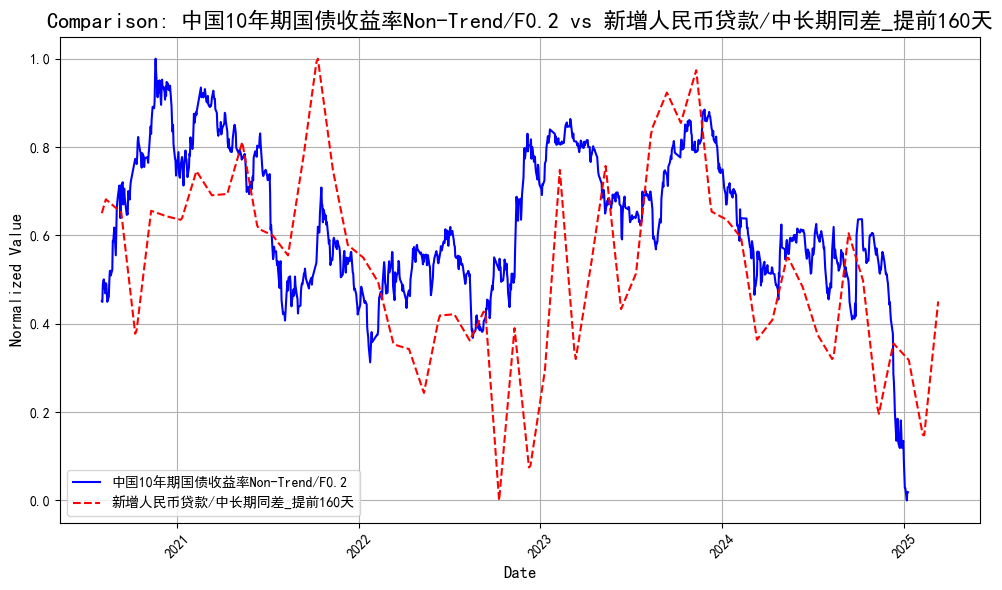

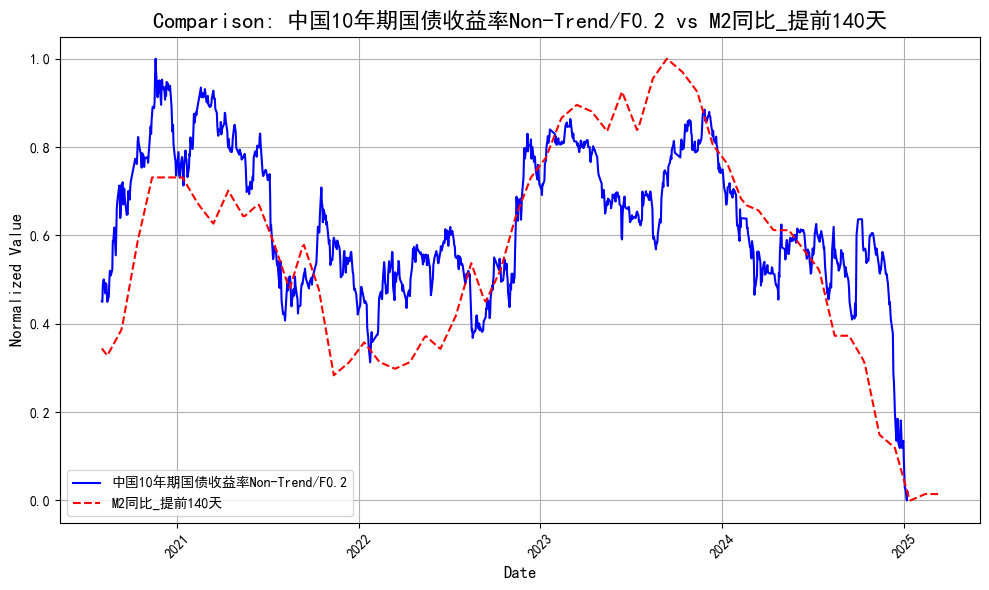

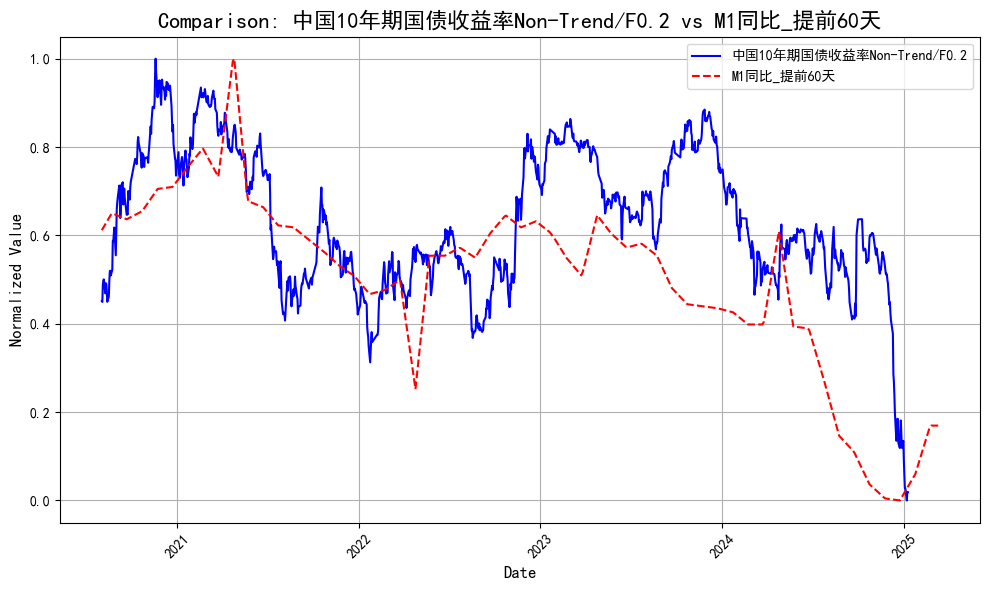

In [8]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='中国10年期国债收益率Non-Trend/F0.2', 
    compare_cols=[
                  '10年期美国国债收益率80日环差_提前80天_2023-01-01之后','南华工业品指数80日环比_提前55天_2022-11-01之后', 
                  '新增人民币贷款/中长期同差_提前160天','M2同比_提前140天','M1同比_提前60天'
                  ] 
)

In [9]:
test  =  sheet_daily['中国10年期国债收益率Non-Trend/F0.2'].corr(sheet_daily['10年期美国国债收益率80日环差_提前80天_2023-01-01之后'])
test

0.5752574074762742

In [10]:
test  =  sheet_daily['中国10年期国债收益率Non-Trend/F0.2'].corr(sheet_daily['南华工业品指数80日环比_提前55天_2022-11-01之后'])
test

0.36950401120470194

In [11]:
# 划分训练集、测试集和未来数据
train_data = sheet_daily[sheet_daily['Date'] <= last_day]
test_period = 50
test_data = train_data[-test_period:]  
train_data = train_data[:-test_period]  
future_data = sheet_daily[sheet_daily['Date'] > last_day]

# 准备训练、测试和未来数据的输入和输出
#feature_columns = ['10年期美国国债收益率80日环差_提前80天', '南华工业品指数80日环比_提前55天',
#                   '新增人民币贷款/中长期同差_提前160天', 'M2同比_提前140天', 'M1同比_提前60天']

feature_columns = ['10年期美国国债收益率80日环差_提前80天_2023-01-01之后','南华工业品指数80日环比_提前55天_2022-11-01之后', 
                  '新增人民币贷款/中长期同差_提前160天','M2同比_提前140天','M1同比_提前60天']

X_train = train_data[feature_columns]
y_train = train_data['中国10年期国债收益率Non-Trend/F0.2']

X_test = test_data[feature_columns]
y_test = test_data['中国10年期国债收益率Non-Trend/F0.2']

X_future = future_data[feature_columns]

# 初始化 MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

In [12]:
# 定义并训练 XGBRegressor 模型
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,          # 树的数量，适当减少
    learning_rate=0.18,        # 降低学习率，提升训练稳定性
    max_depth=5,               # 降低树的深度，避免过拟合
    min_child_weight=1,        # 提高对分裂的要求，避免过拟合
    subsample=1,             # 适度保留子样本比例
    colsample_bytree=1,      # 保留特征比例，单特征时也可保持默认
    gamma=1,                 # 增大分裂惩罚，避免过拟合
    reg_alpha=1,             # 增加L1正则化
    reg_lambda=1,            # 增加L2正则化
    random_state=42            # 固定随机种子，确保复现性
)

xgb.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
)

y_train_pred = xgb.predict(X_train_scaled)
y_test_pred = xgb.predict(X_test_scaled)


train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse}, Train R^2: {train_r2}")
print(f"Test MSE: {test_mse}, Test R^2: {test_r2}")


# 使用所有历史数据重新训练模型
X_all = sheet_daily[sheet_daily['Date'] <= last_day][feature_columns]
y_all = sheet_daily[sheet_daily['Date'] <= last_day]['中国10年期国债收益率Non-Trend/F0.2']
# 归一化所有历史数据
X_all_scaled = scaler.fit_transform(X_all)
xgb.fit(X_all_scaled, y_all)


y_future_pred = xgb.predict(X_future_scaled)

test_data = test_data.copy()
future_data = future_data.copy()

test_data.loc[:, '预测值'] = y_test_pred
future_data.loc[:, '预测值'] = y_future_pred

[0]	validation_0-rmse:0.10536	validation_1-rmse:0.27055
[1]	validation_0-rmse:0.09655	validation_1-rmse:0.26012
[2]	validation_0-rmse:0.09009	validation_1-rmse:0.25194
[3]	validation_0-rmse:0.08539	validation_1-rmse:0.24519
[4]	validation_0-rmse:0.07859	validation_1-rmse:0.23828
[5]	validation_0-rmse:0.07566	validation_1-rmse:0.23606
[6]	validation_0-rmse:0.07331	validation_1-rmse:0.23284
[7]	validation_0-rmse:0.07331	validation_1-rmse:0.23284
[8]	validation_0-rmse:0.07331	validation_1-rmse:0.23284
[9]	validation_0-rmse:0.07331	validation_1-rmse:0.23284
[10]	validation_0-rmse:0.07331	validation_1-rmse:0.23284
[11]	validation_0-rmse:0.07331	validation_1-rmse:0.23284
[12]	validation_0-rmse:0.07331	validation_1-rmse:0.23284
[13]	validation_0-rmse:0.07331	validation_1-rmse:0.23284
[14]	validation_0-rmse:0.07331	validation_1-rmse:0.23284
[15]	validation_0-rmse:0.07331	validation_1-rmse:0.23284
[16]	validation_0-rmse:0.07331	validation_1-rmse:0.23284
[17]	validation_0-rmse:0.07331	validation

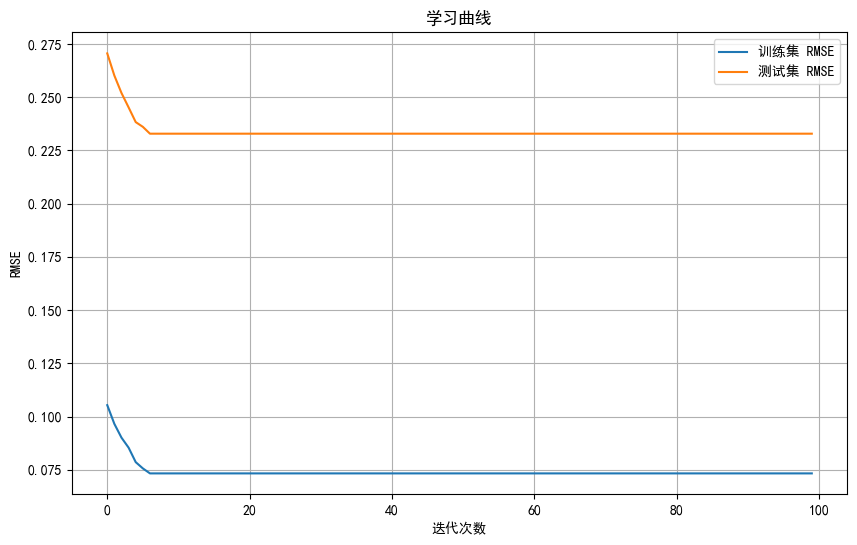

In [13]:
# 学习曲线可视化
results = xgb.evals_result()
plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['rmse'], label='训练集 RMSE')
plt.plot(results['validation_1']['rmse'], label='测试集 RMSE')
plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('学习曲线')
plt.legend()
plt.grid(True)
plt.show()

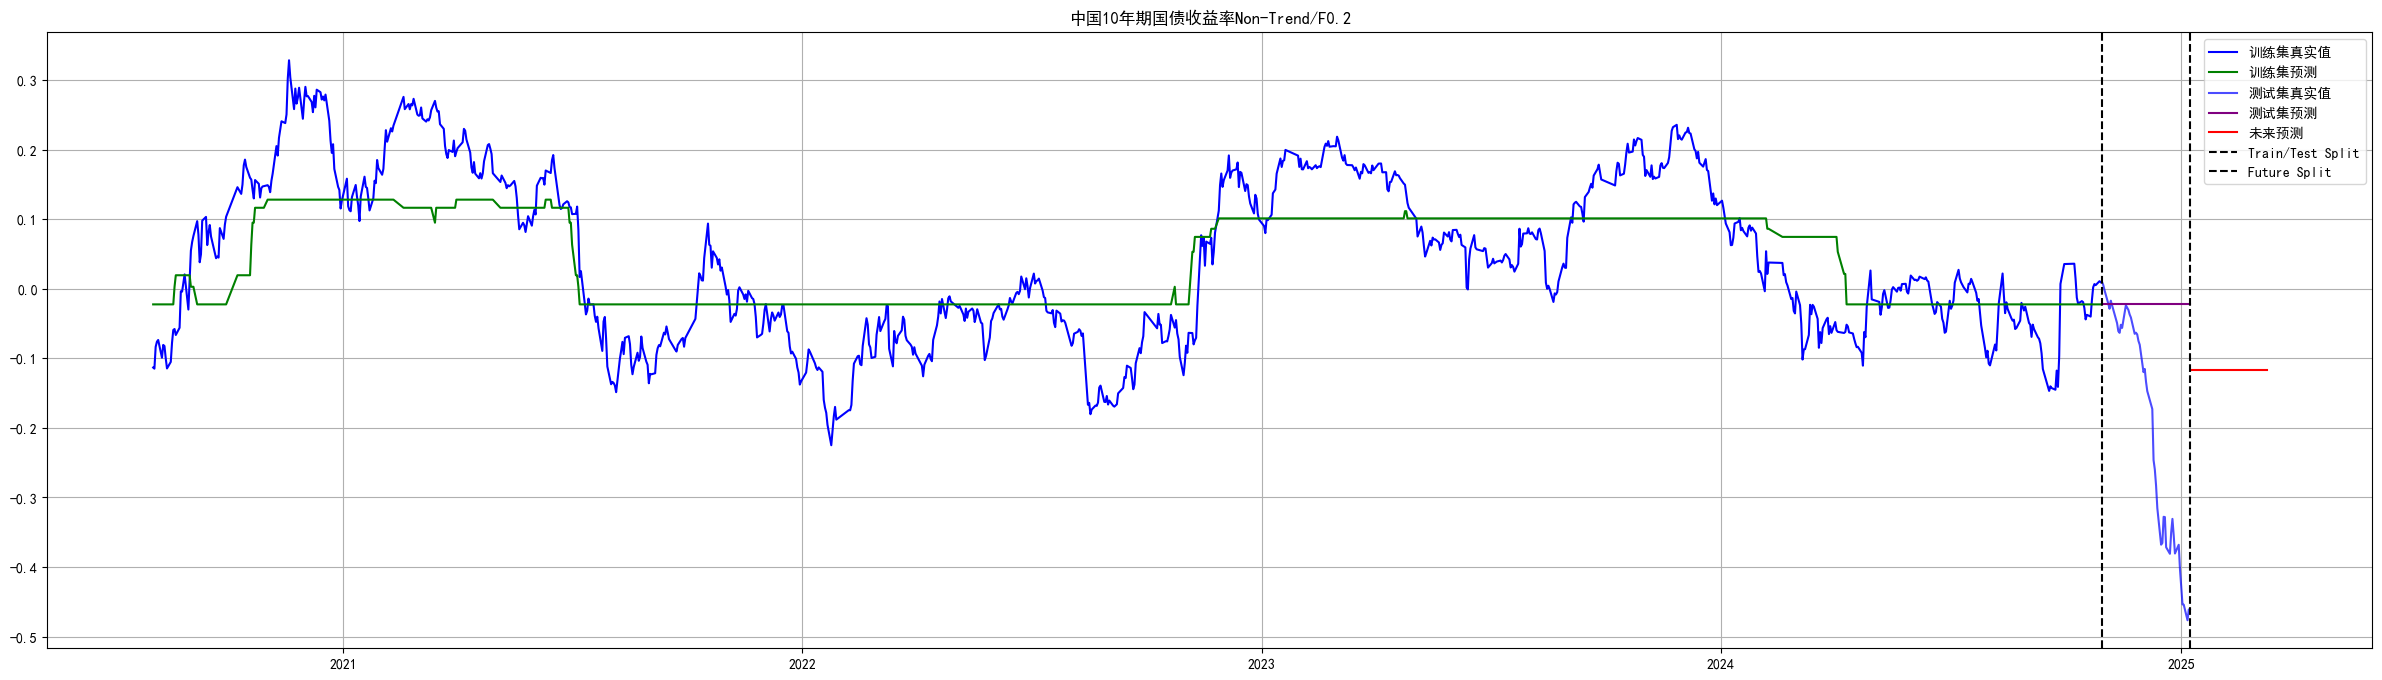

In [14]:
# 可视化
plt.figure(figsize=(30, 8))
plt.plot(train_data['Date'], y_train, label='训练集真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集真实值', color='blue',alpha=0.7)
plt.plot(test_data['Date'], test_data['预测值'], label='测试集预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')

plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('中国10年期国债收益率Non-Trend/F0.2')
plt.legend()
plt.grid(True)
plt.show()

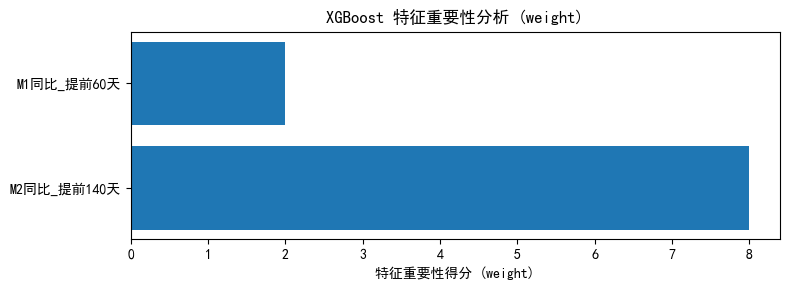

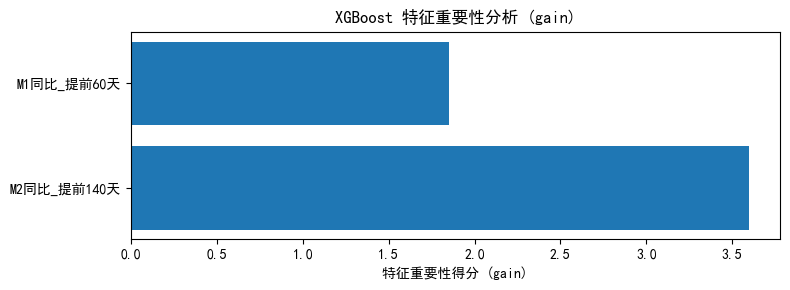

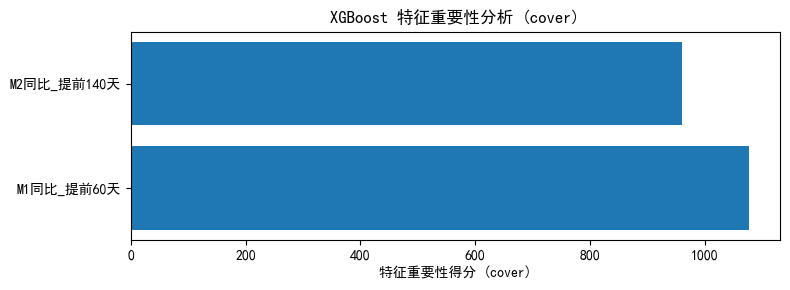

In [15]:
# 获取模型的 booster
booster = xgb.get_booster()

# 将 f0, f1 等映射到实际的特征名称
feature_names = X_train.columns  # 假设这是您的特征名称列表
feature_map = {f'f{i}': name for i, name in enumerate(feature_names)}

# 绘制 weight、gain 和 cover 的特征重要性图
plot_feature_importance(booster, 'weight', feature_map, 'XGBoost 特征重要性分析 (weight)', '特征重要性得分 (weight)')
plot_feature_importance(booster, 'gain', feature_map, 'XGBoost 特征重要性分析 (gain)', '特征重要性得分 (gain)')
plot_feature_importance(booster, 'cover', feature_map, 'XGBoost 特征重要性分析 (cover)', '特征重要性得分 (cover)')

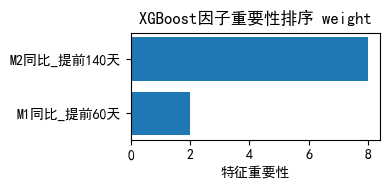

In [16]:
# 创建特征重要性排序的DataFrame
plt.figure(figsize=(4, 2))
importance_type = 'weight'
feature_importance = booster.get_score(importance_type=importance_type)

importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})

# 将特征名称从f0、f1等映射到实际的列名
feature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))
importance_df['feature_name'] = importance_df['feature'].map(feature_names)

# 按重要性降序排序
importance_df_sorted = importance_df.sort_values('importance', ascending=True)

# 绘制水平条形图
plt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])
plt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)
plt.xlabel('特征重要性')
plt.title('XGBoost因子重要性排序 weight')
plt.tight_layout()
plt.show()


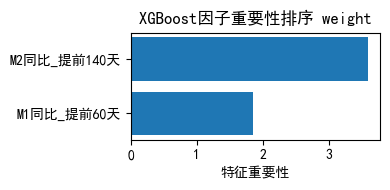

In [17]:
# 创建特征重要性排序的DataFrame
plt.figure(figsize=(4, 2))
importance_type = 'gain'
feature_importance = booster.get_score(importance_type=importance_type)

importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})

# 将特征名称从f0、f1等映射到实际的列名
feature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))
importance_df['feature_name'] = importance_df['feature'].map(feature_names)

# 按重要性降序排序
importance_df_sorted = importance_df.sort_values('importance', ascending=True)

# 绘制水平条形图
plt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])
plt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)
plt.xlabel('特征重要性')
plt.title('XGBoost因子重要性排序 weight')
plt.tight_layout()
plt.show()


In [18]:
print(sheet_daily[feature_columns].describe())


       10年期美国国债收益率80日环差_提前80天_2023-01-01之后  南华工业品指数80日环比_提前55天_2022-11-01之后  \
count                           532.000000                       576.000000   
mean                              0.142946                         0.001630   
std                               0.533551                         0.077060   
min                              -0.880000                        -0.182400   
25%                              -0.250000                        -0.063325   
50%                               0.065000                         0.003800   
75%                               0.620000                         0.049275   
max                               1.260000                         0.223000   

       新增人民币贷款/中长期同差_提前160天  M2同比_提前140天   M1同比_提前60天  
count           1120.000000  1120.000000  1120.000000  
mean             514.360670     9.970931     3.558148  
std             4162.837648     1.659997     4.417106  
min           -10520.000000     6.203226    -7.400000  
25%     

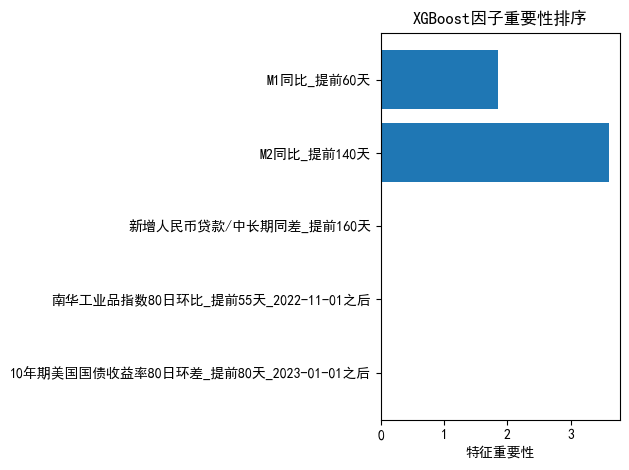

In [19]:
# 生成完整特征重要性 DataFrame
importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
}).sort_values('importance', ascending=True)

# 映射特征名称
feature_names = dict(zip([f'f{i}' for i in range(len(feature_columns))], feature_columns))
importance_df['feature_name'] = importance_df['feature'].map(feature_names)

# 显示未使用的重要性为0的特征
all_features = pd.DataFrame({'feature_name': feature_columns})
importance_df = pd.merge(all_features, importance_df, on='feature_name', how='left').fillna(0)

# 绘制重要性图
plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature_name'], fontsize=10)
plt.xlabel('特征重要性')
plt.title('XGBoost因子重要性排序')
plt.tight_layout()
plt.show()

